<a href="https://colab.research.google.com/github/michel-vbarboza/ERA5-Temperature-Prediction/blob/main/XGBoost_(GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MMEAD Dissertacao/Dados/'

# Preprocessing

In [ ]:
with open(path+'train.pkl', 'rb') as f:
    train = pickle.load(f)

with open(path+'test.pkl', 'rb') as f:
    test = pickle.load(f)

del f

In [ ]:
targets = ['target_1', 'target_3', 'target_5',
           'target_7', 'target_10', 'target_15']

features = train.columns.difference(targets)

In [ ]:
train[targets] = train[targets] - 273.15
test[targets] = test[targets] - 273.15

In [ ]:
target = 'target_1'

In [ ]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Extreme Gradient Boosting

In [ ]:
# Convert DataFrames to DMatrix
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)


In [ ]:
# Define the XGBoost parameters for using CUDA
params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'tree_method': 'hist',             # Use histogram-based tree method
    'device': 'cuda',                  # Use CUDA for GPU acceleration
    'max_depth': 5,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'nthread': -1,
    'verbosity': 2,
    'eta': 0.1

}

# Perform cross-validation on the training data
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=10_000,
    nfold=5,
    metrics='rmse',
    early_stopping_rounds=1000,
    seed=42,
    as_pandas=True,
    verbose_eval=True
)

# Train the model on the full training data using the number of rounds found in cross-validation
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=len(cv_results)
)

# Predict on the test set
y_pred = model.predict(dtest)

# Evaluate the model performance on the test set using RMSE
test_rmse = np.sqrt(mean_squared_error(dtest.get_label(), y_pred))
print(f'RMSE on test data: {test_rmse}')

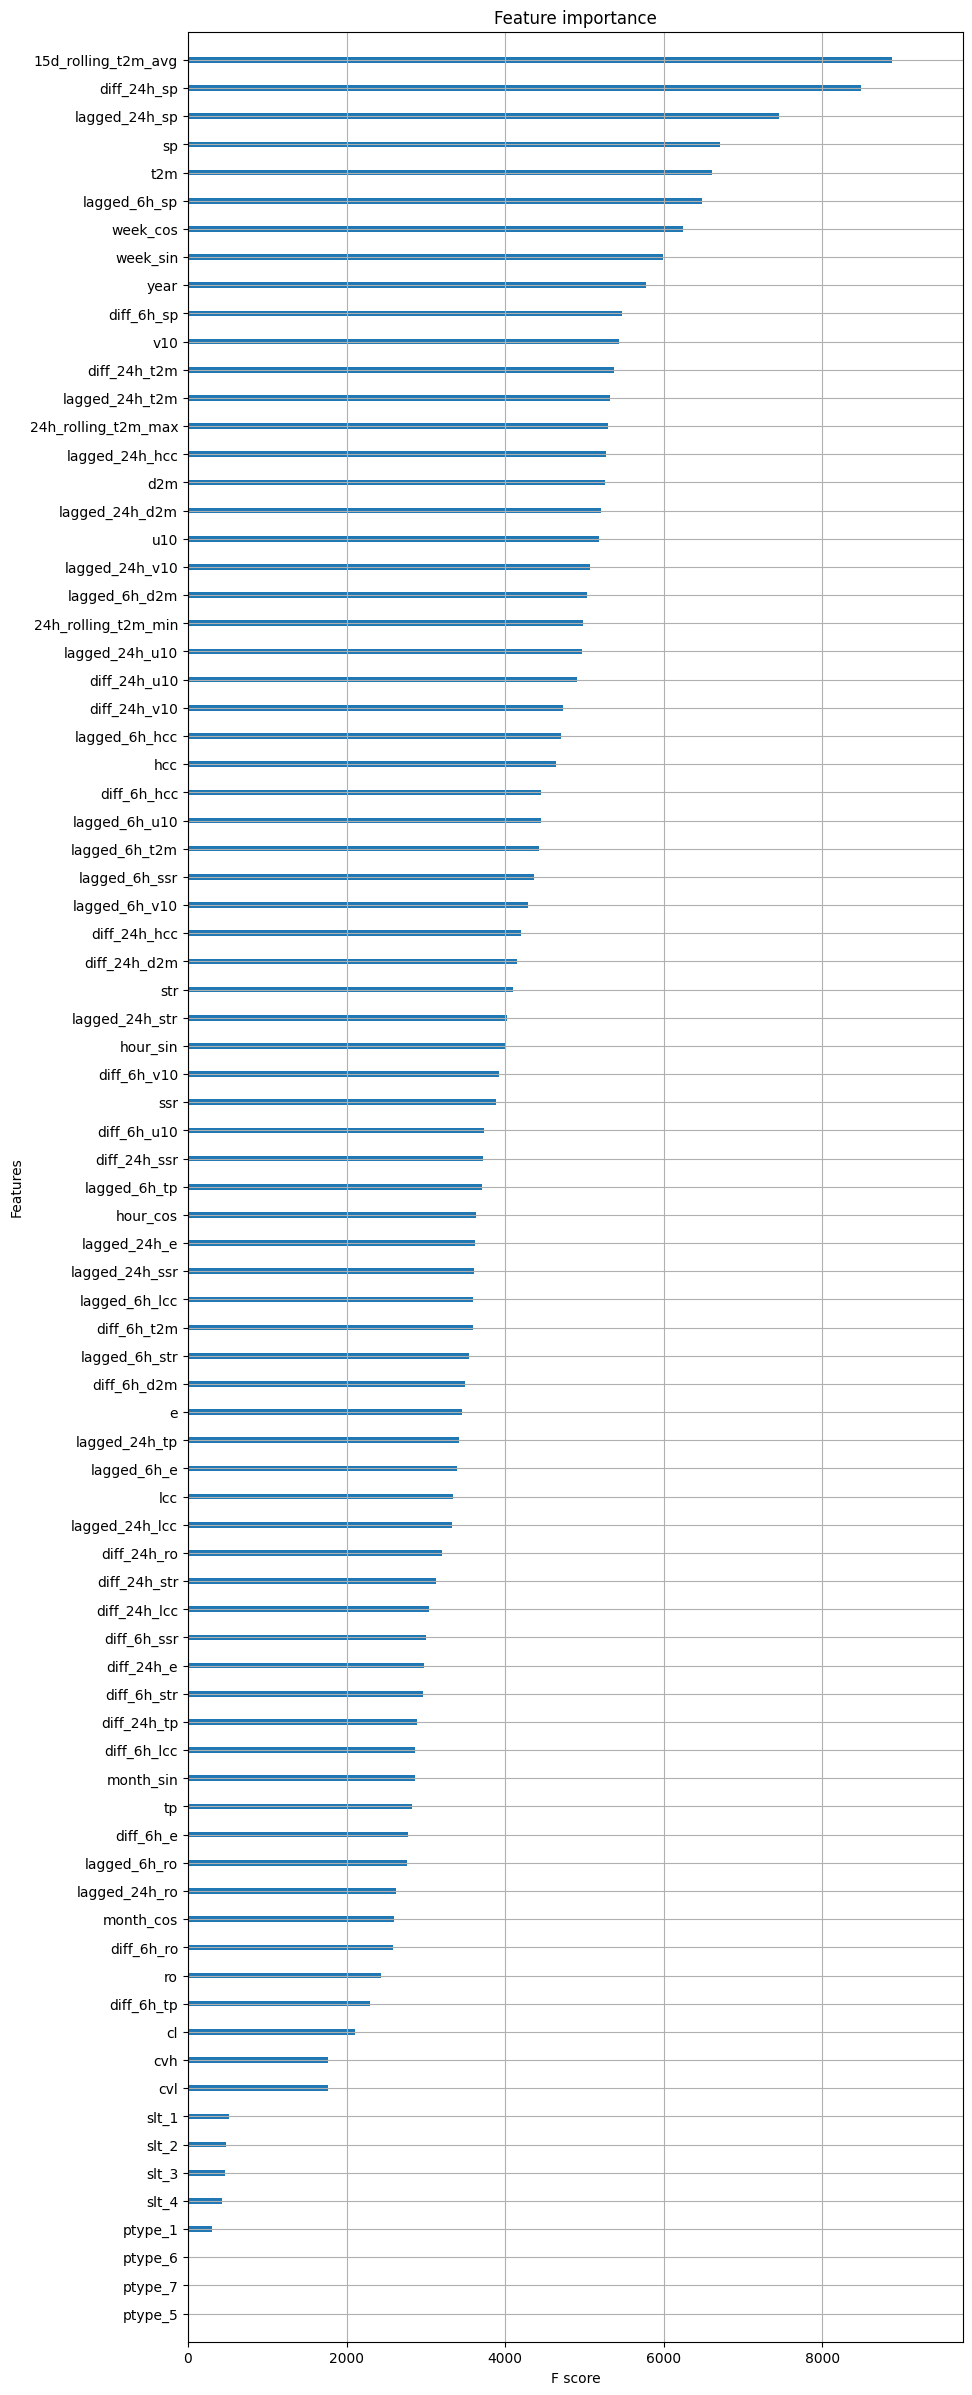

In [ ]:
# Plot feature importance with custom figure size
xgb.plot_importance(model, importance_type='weight', show_values=False, height=0.2)
plt.rcParams['figure.figsize'] = [10, 30]
plt.show()

In [ ]:
# Evaluate the model performance on the test set using RMSE
test_rmse2 = np.sqrt(mean_squared_error(np.roll(y_pred, 1), y_pred))
print(f'RMSE on test data: {test_rmse2}')

RMSE on test data: 1.979394555091858


In [ ]:
y_pred

array([15.859394, 15.632978, 15.882805, ..., 16.519793, 16.980824,
       17.101633], dtype=float32)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'device': 'cuda',
        'eta': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.5, 0.6, 0.7, 0.8]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }

    num_round = trial.suggest_int('n_estimators', 100, 1000, step=50)

    # Perform cross-validation
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_round,
        nfold=5,  # Number of folds for cross-validation
        metrics='rmse',
        early_stopping_rounds=100,
        #verbose_eval=False
    )

    # Extract the best RMSE from cross-validation results
    rmse_val = cv_results['test-rmse-mean'].min()

    return rmse_val

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1) # n_jobs = 2 is a bottleneck

# Print the best parameters
print(f'Best parameters: {study.best_params}')

# Train the model with the best parameters on the entire training data
best_params = study.best_params
best_params['device'] = 'cuda'
num_round = best_params.pop('num_round', 100)  # Use a default value if 'num_round' was not saved in the best parameters

# Train the model with the best parameters
bst = xgb.train(best_params, dtrain, num_boost_round=num_round)

# Predict on the test set
y_test_pred = bst.predict(dtest)

# Calculate RMSE for the test set
rmse_test = mean_squared_error(y_test.to_numpy(), y_test_pred, squared=False)
print(f'Test RMSE: {rmse_test}')

[I 2024-08-29 19:27:21,830] A new study created in memory with name: no-name-0dfabd5a-8fcf-4d72-9f65-d7a2386f037b


KeyboardInterrupt: 

In [ ]:
# Access the feature importance
feature_importance = bst.get_score(importance_type='weight')

# Print or visualize the feature importance
print("Feature Importance (by weight):")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance}")


Feature Importance (by weight):
15d_rolling_avg: 127566.0
30d_rolling_avg: 69156.0
7d_rolling_avg: 52960.0
cl: 19020.0
cvh: 20882.0
cvl: 16871.0
d2m: 50414.0
day: 39844.0
diff1_d2m: 41158.0
diff1_e: 36050.0
diff1_hcc: 36723.0
diff1_lcc: 31816.0
diff1_ro: 30258.0
diff1_sp: 43903.0
diff1_ssr: 28579.0
diff1_str: 25264.0
diff1_t2m: 36797.0
diff1_tp: 24861.0
diff1_u10: 40198.0
diff1_v10: 35384.0
e: 26490.0
hcc: 32155.0
hour_cos: 25023.0
hour_sin: 21954.0
lag1_d2m: 31717.0
lag1_e: 24513.0
lag1_hcc: 26567.0
lag1_lcc: 23371.0
lag1_ro: 22324.0
lag1_sp: 33464.0
lag1_ssr: 22628.0
lag1_str: 23248.0
lag1_t2m: 25300.0
lag1_tp: 18768.0
lag1_u10: 32146.0
lag1_v10: 32335.0
lcc: 20692.0
month_cos: 6210.0
month_sin: 3615.0
ptype_1: 1463.0
ptype_5: 4.0
ptype_6: 21.0
ptype_7: 6.0
ro: 19406.0
slt_1: 1752.0
slt_2: 1842.0
slt_3: 2290.0
slt_4: 1090.0
sp: 35530.0
ssr: 19982.0
str: 26812.0
t2m: 27689.0
tp: 20447.0
u10: 34491.0
v10: 33729.0
week: 16589.0
year: 13095.0


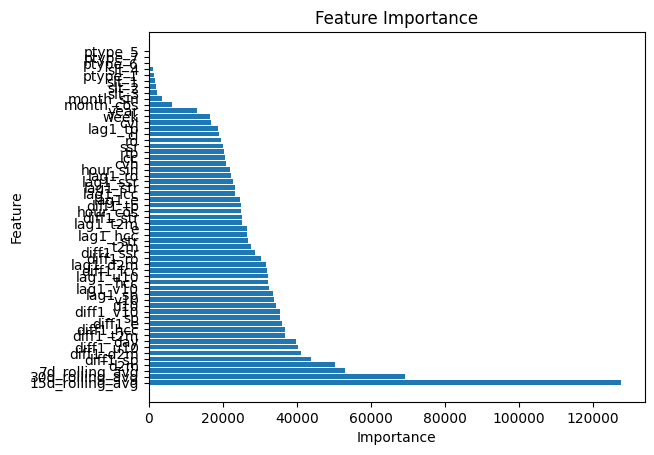

In [ ]:
# Convert the feature importance dictionary to a sorted list of tuples
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plot the feature importance
features, importances = zip(*sorted_importance)
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# Save lists using pickle
with open(path+'global_pred_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(y_test_pred, f)

with open(path+'global_rmse_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(rmse_test, f)

with open(path+'global_best_params_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(best_params, f)

Testes

In [ ]:
# Define the objective function for Optuna
def objective(trial):

    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
       # 'device': 'cuda',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'eta': trial.suggest_float('eta', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)
    }

    # Perform cross-validation
    num_round = trial.suggest_int('num_round', 100, 1000)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        #num_boost_round=num_round,
        nfold=5,  # Number of folds for cross-validation
        metrics='rmse',
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Extract the best RMSE from cross-validation results
    rmse_val = cv_results['test-rmse-mean'].min()

    return rmse_val

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=1) # n_jobs = 2 is a bottleneck

# Print the best parameters
print(f'Best parameters: {study.best_params}')

# Train the model with the best parameters on the entire training data
best_params = study.best_params
#best_params['device'] = 'cuda'
num_round = best_params.pop('num_round', 100)  # Use a default value if 'num_round' was not saved in the best parameters

# Train the model with the best parameters
bst = xgb.train(best_params, dtrain, num_boost_round=num_round)

# Predict on the test set
y_test_pred = bst.predict(dtest)

# Calculate RMSE for the test set
rmse_test = mean_squared_error(y_test.to_numpy(), y_test_pred, squared=False)
print(f'Test RMSE: {rmse_test}')

[I 2024-08-27 10:53:54,814] A new study created in memory with name: no-name-1aaa60bc-2f15-4488-9d8b-a123242caa85
[I 2024-08-27 10:54:11,990] Trial 0 finished with value: 3.2993864784176927 and parameters: {'max_depth': 5, 'eta': 0.11674672555025417, 'subsample': 0.5458401924611502, 'colsample_bytree': 0.6923274991344754, 'min_child_weight': 5, 'reg_alpha': 0.0001900567456511874, 'reg_lambda': 0.00016547678271553018, 'num_round': 856}. Best is trial 0 with value: 3.2993864784176927.
[I 2024-08-27 10:54:28,730] Trial 1 finished with value: 2.769374375200147 and parameters: {'max_depth': 4, 'eta': 0.21000165726320677, 'subsample': 0.5131244027145185, 'colsample_bytree': 0.5638354016336187, 'min_child_weight': 8, 'reg_alpha': 0.00033364298143796816, 'reg_lambda': 0.0002140729287571285, 'num_round': 773}. Best is trial 1 with value: 2.769374375200147.
[I 2024-08-27 10:54:46,057] Trial 2 finished with value: 7.1203538685250365 and parameters: {'max_depth': 4, 'eta': 0.00010965288536325446, 

Best parameters: {'max_depth': 6, 'eta': 0.2963777156202345, 'subsample': 0.7812465802357648, 'colsample_bytree': 0.7879366724367547, 'min_child_weight': 10, 'reg_alpha': 0.05847399777159786, 'reg_lambda': 0.8852991758265617, 'num_round': 930}
Test RMSE: 2.0823735617053676
